Lib setup

In [2]:
import os
import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sqlalchemy import create_engine, text


Loader

In [6]:
def load_config(CONFIG_PATH):
    with open(CONFIG_PATH, "r", encoding="utf-8") as file:
        return yaml.safe_load(file)

BASE_DIR = Path().resolve().parent.parent
CONFIG_PATH = BASE_DIR / "config" / "config.yaml"

config = load_config(CONFIG_PATH)

pg_conf = config["postgres"]

MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True, parents=True)
MODEL_OUT = MODEL_DIR / "cars_rf.joblib"

DATA_PATH = os.path.join(BASE_DIR, config["parsing"]["save_path_processed_cleaned"],"CarsData.csv")

# load data sql -> pandas
def load_dataframe():
    try:
        engine = create_engine(
        f"postgresql+psycopg2://{pg_conf['user']}:{pg_conf['password']}@{pg_conf['host']}:{pg_conf['port']}/{pg_conf['database']}"
        )
        with engine.connect() as conn:
            df = pd.read_sql(text("SELECT * FROM cars"), conn)
        print("Dados carregados do Postgres.")
        return df
    except Exception as e:
        print("Falha ao carregar do Postgres, caindo para CSV. Erro:", e)
    
        try:
            df = pd.read_csv(DATA_PATH)
            print(f"Dados carregados do CSV: {DATA_PATH}")
            return df
        except:
            raise FileNotFoundError("Nenhuma fonte de dados disponível (PG ou data/cars.csv)")
        
df = load_dataframe()
print(df.head())

Dados carregados do Postgres.
           model  year  price transmission  mileage fueltype  tax   mpg  \
0            I10  2017   7495       Manual    11630   Petrol  145  60.1   
1           Polo  2017  10989       Manual     9200   Petrol  145  58.9   
2       2 Series  2019  27990    Semi-Auto     1614   Diesel  145  49.6   
3   Yeti Outdoor  2017  12495       Manual    30960   Diesel  150  62.8   
4         Fiesta  2017   7999       Manual    19353   Petrol  125  54.3   

   enginesize manufacturer  car_age  price_per_engine  
0         1.0      Hyundai        8       7495.000000  
1         1.0   Volkswagen        8      10989.000000  
2         2.0          Bmw        6      13995.000000  
3         2.0        Skoda        8       6247.500000  
4         1.2         Ford        8       6665.833333  


Barplot

C:\Users\diego\AppData\Local\Temp\ipykernel_3540\2965014037.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="manufacturer", y="price", ci=None, estimator=np.mean)


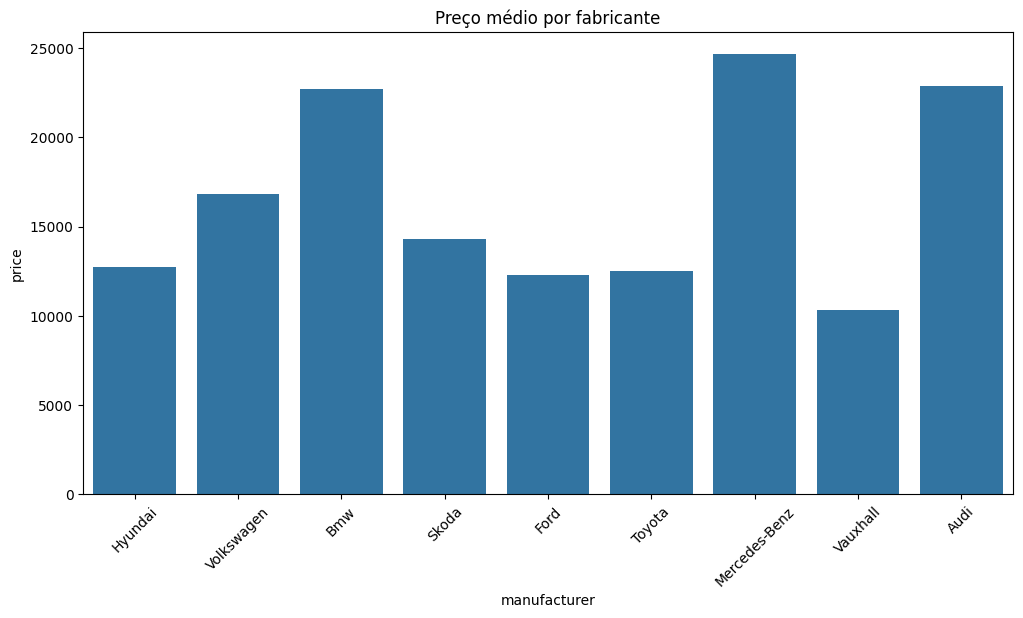

In [8]:

plt.figure(figsize=(12,6))
sns.barplot(data=df, x="manufacturer", y="price", ci=None, estimator=np.mean)
plt.xticks(rotation=45)
plt.title("Preço médio por fabricante")
plt.show()

Variables Ploting

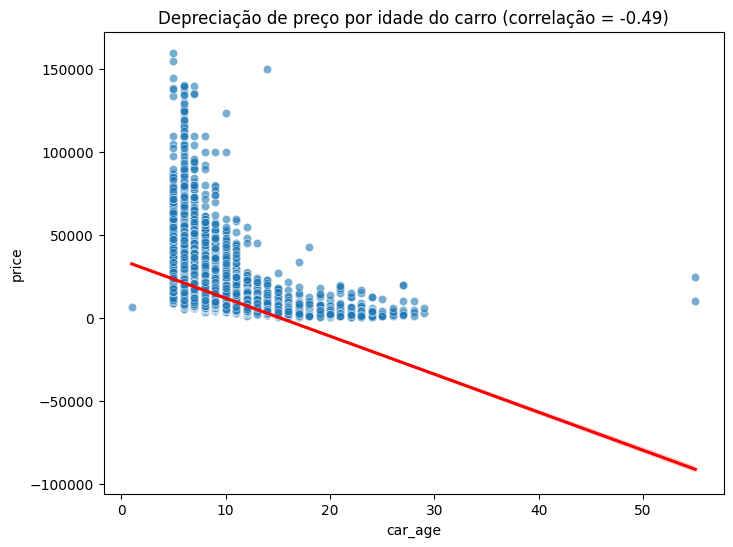

In [7]:
correlation = df["car_age"].corr(df["price"])


plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="car_age", y="price", alpha=0.6)
sns.regplot(data=df, x="car_age", y="price", scatter=False, color="red")
plt.title(f"Depreciação de preço por idade do carro (correlação = {correlation:.2f})")
plt.show()

Correlation Heatmap - target

Dados carregados do Postgres.


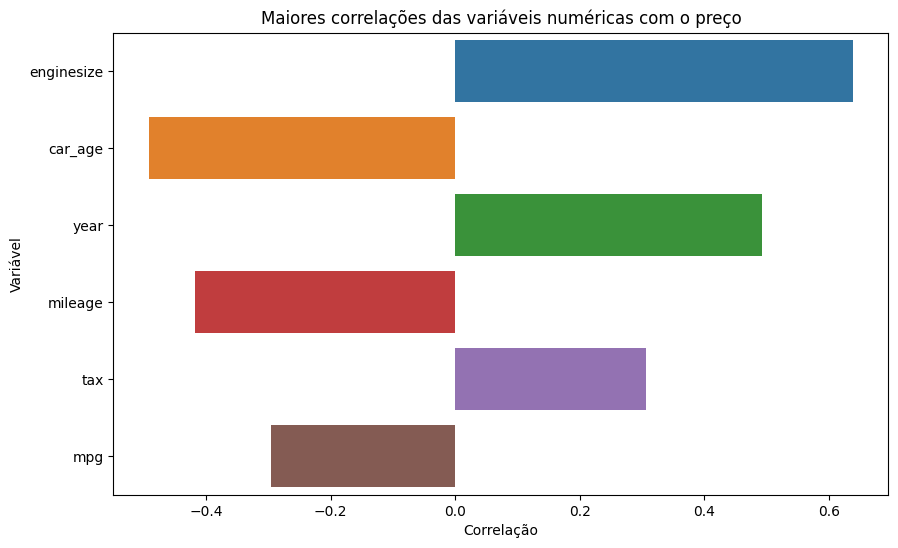

In [19]:
df = load_dataframe()
df.drop(columns=["price_per_engine"], inplace=True)
numeric_df = df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr()
price_corr = corr_matrix["price"].drop("price").sort_values(key=abs, ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=price_corr.values, y=price_corr.index, hue = price_corr.index, legend= False)
plt.title("Maiores correlações das variáveis numéricas com o preço")
plt.xlabel("Correlação")
plt.ylabel("Variável")
plt.show()

ML Modeling

Dados carregados do Postgres.
Numéric: ['year', 'mileage', 'tax', 'mpg', 'enginesize', 'car_age']
Categorical: ['model', 'transmission', 'fueltype', 'manufacturer']
after cleaning -> X: (97712, 10) y: (97712,)
Split -> Train: (78169, 10) Test: (19543, 10)
Attempt to training RandomForest
Model trained sucessfully.
Avaliação no conjunto de teste:
  RMSE: 2072.26
  MAE : 1142.17
  R²  : 0.956


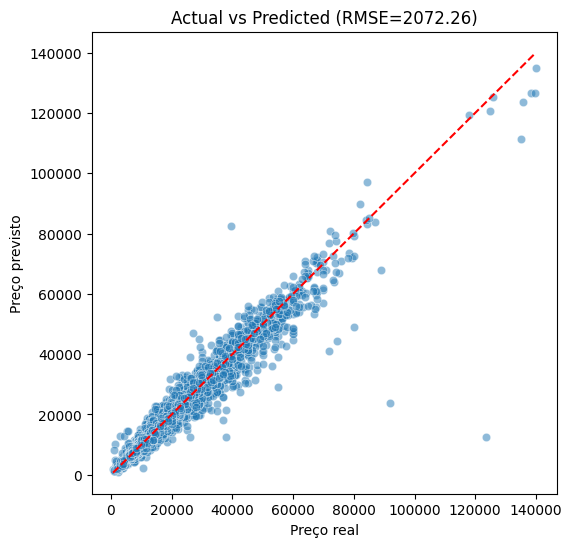

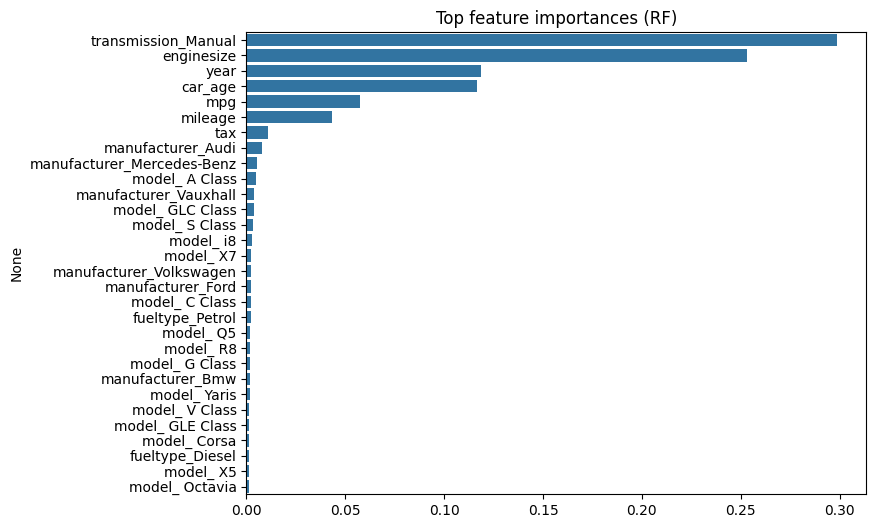

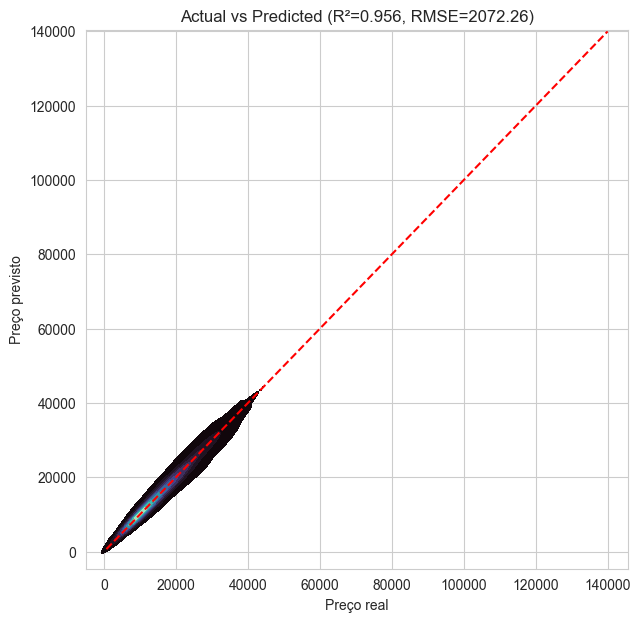

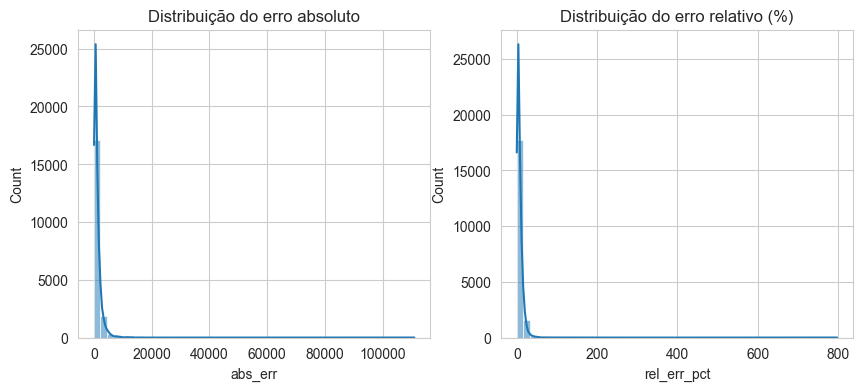

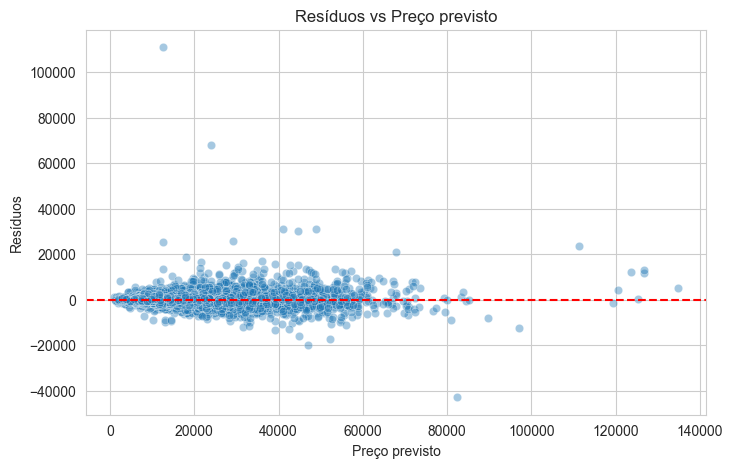

In [ ]:

df = load_dataframe()


for c in ["index", "Unnamed: 0"]:
    if c in df.columns:
        df = df.drop(columns=[c])



df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna(subset=["price"]).reset_index(drop=True)


num_feats = [c for c in ["year", "mileage", "tax", "mpg", "enginesize", "car_age"] if c in df.columns]
cat_feats = [c for c in ["model", "transmission", "fueltype", "manufacturer"] if c in df.columns]
print("Numéric:", num_feats)
print("Categorical:", cat_feats)


X = df[num_feats + cat_feats].copy()
y = df["price"].copy()


for c in num_feats:
    X[c] = pd.to_numeric(X[c], errors="coerce")


X.replace([np.inf, -np.inf], np.nan, inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)


valid_mask = y.notna()
X = X.loc[valid_mask].reset_index(drop=True)
y = y.loc[valid_mask].reset_index(drop=True)

print("after cleaning -> X:", X.shape, "y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Split -> Train:", X_train.shape, "Test:", X_test.shape)


numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])



ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", ohe)
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_feats),
    ("cat", categorical_transformer, cat_feats)
], remainder="drop")


rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)  

pipeline = Pipeline([
    ("pre", preprocessor),
    ("rf", rf)
])


print("Attempt to training RandomForest")
pipeline.fit(X_train, y_train)
print("Model trained sucessfully.")

y_pred = pipeline.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Avaliação no conjunto de teste:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE : {mae:.2f}")
print(f"  R²  : {r2:.3f}")


plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Preço real")
plt.ylabel("Preço previsto")
plt.title(f"Real vs Previsto (RMSE={rmse:.2f})")
plt.show()



try:
    pre = pipeline.named_steps["pre"]
    num_names = num_feats
    cat_names = []
    if cat_feats:
        
        cat_transformer = pre.named_transformers_["cat"]
        
        if hasattr(cat_transformer, "named_steps"):
            encoder = cat_transformer.named_steps.get("onehot")
        else:
            encoder = cat_transformer  
        try:
            cat_names = list(encoder.get_feature_names_out(cat_feats))
        except Exception:
           
            cat_names = list(encoder.get_feature_names(cat_feats))
    feature_names = num_names + cat_names
    importances = pipeline.named_steps["rf"].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title("Avaliação de Features (RF)")
    plt.show()
except Exception as e:
    print("Não foi possível extrair feature importances:", e)



sns.set_style("whitegrid")


plt.figure(figsize=(7,7))
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='mako', thresh=0.05)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Preço real')
plt.ylabel('Preço previsto')
plt.title(f'Real vs Previsto (R²={r2:.3f}, RMSE={rmse:.2f})')
plt.show()


results = pd.DataFrame({'real': y_test, 'pred': y_pred})
results['abs_err'] = (results['real'] - results['pred']).abs()
results['rel_err_pct'] = results['abs_err'] / results['real'].replace(0, np.nan) * 100

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(results['abs_err'], bins=50, kde=True)
plt.title('Distribuição do erro absoluto')

plt.subplot(1,2,2)
sns.histplot(results['rel_err_pct'], bins=50, kde=True)
plt.title('Distribuição do erro relativo (%)')
plt.show()


residuals = results['actual'] - results['pred']
plt.figure(figsize=(8,5))
sns.scatterplot(x=results['pred'], y=residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Preço previsto')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Preço previsto')
plt.show()
